### Optimizing polynomials with strange ways

We'll be minimizing single and multivariable quartic functions (without using the knowledge it is one) in this file to see if we can make this stuff actually work. This leads up to attempting to use these methods on a machine learning model in the other file (ScikitModels.ipynb).

Author: Raido Everest

In [1]:
import random
import numpy as np
from scipy.optimize import minimize  # checking goodness of result compared to scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
# Function to generate functions to test on
def quartic():
    # default ranges for variables too
    a, b = random.random() * 4.9 + 0.1, random.random() * 10 - 5
    c, d = random.random() * 40 - 20, random.random() * 500 - 250
    
    return lambda x: a * x**4 + b * x**3 + c * x**2 + d * x

# Making an nd-quartic function to test higher dimensionalities.
# For the sake of generality, this should be used for the single variable case as well.
# n - how many inputs the function takes
# outputs the sum of n random quartic functions
def quartic_n(n):
    fs = [quartic() for _ in range(n)]
    return lambda answers: sum(map(lambda pair: pair[0](pair[1]), zip(fs, answers)))

# Example scipy optimization of a 4d quartic function:
# minimize(quartic_n(4), (0,0,0,0))

# Implementations

### Differential Evolution

In [3]:
# The main function that returns the best set of inputs it finds.
# f - the function.
# n - input dimensionality
# k - population size
# scaling - the scaling parameter when creating a new input set
# loops   - how many loops it will do before giving up finding a better solution
# Outputs the minimum value of the function that it found and the necessary input for it
def diff_evo(f, n, k = 80, scaling = 0.5, loops=25):
    # Create initial input set
    pop       = create_population(n, k)
    fitnesses = calculate_fitness(f, pop)
    best, bestval = getbest(pop, fitnesses)   # pair of best input and its value
    
    loops_since_improvement = 0  # Keep it going until it's not working anymore.
    while loops_since_improvement < loops:
        loops_since_improvement += 1
        
        # Create next population by mutating previous one
        newpop       = create_next_population(pop, scaling)
        newfitnesses = calculate_fitness(f, newpop)
        nextbest, nextbestval = getbest(newpop, newfitnesses)
        
        # Keep track of what the best outcome is
        if nextbestval < bestval:
            best, bestval = nextbest, nextbestval
            loops_since_improvement = 0
        
        # Always choose the better one of the two choices to represent the 'next generation'
        for i in range(k):
            if newfitnesses[i] < fitnesses[i]:  # if something must be changed
                pop[i], fitnesses[i] = newpop[i], newfitnesses[i]
    
    # Return the best value and its inputs
    return bestval, best

# Creates a population not knowing any previous information
# n - dimensionality of output
# k - population size
def create_population(n, k):
    # Arbitrary range, but should be fine for the time being.
    return [[random.random() * 200 - 100 for _ in range(n)] for _ in range(k)]

# Creates the next generation of input sets
# pop - the old population
# scaling - the scaling parameter
def create_next_population(pop, scaling = 0.5):
    dim = len(pop[0])
    n = len(pop)
    
    newpop = [None] * n
    for i in range(n):
        a, b = random.randint(0, n-1), random.randint(0, n-1)  # Indices of two random elements
        diff = [(pop[a][d] - pop[b][d]) for d in range(dim)]   # Difference of two random input vectors
        newpop[i] = [pop[i][d] + diff[d] * scaling for d in range(dim)]  # Mutated input has been created
    
    return newpop

# Just makes a list of evaluation results
def calculate_fitness(f, pop):
    return [f(inputs) for inputs in pop]

# Given a population and fitnesses, returns the best element and its fitness.
def getbest(pop, fitnesses):
    best, bestfitness = pop[0], fitnesses[0]
    for i in range(1, len(fitnesses)):
        if fitnesses[i] < bestfitness:
            best, bestfitness = pop[i], fitnesses[i]
    return best, bestfitness

### Particle Swarm Optimization

In [4]:
# This is a super dodgy PSO that resets move speed to some fixed baseline at random times.
# f - the function.
# n - input dimensionality
# k - population size
# loops   - how many loops it will do before giving up finding a better solution
# lr - how much velocity affects future velocity (between 0 and 1)
# c1 and c2 - weighting for personal and overall best when moving  (between 0 and 1)
# res_speed - the speed we may reset to randomly
# res_speed_p - probability of reset
# Outputs the minimum value of the function that it found and the necessary input for it
def pso(f, n, k=25, loops=25, lr=1.0, c1=0.5, c2=0.5, res_speed=10, res_speed_p=0.1):
    # Create initial population - including velocity, personal best locations
    pop, velocity, pb_locs = create_pso(n, k)
    # Also calculate personal best actual values.
    pb_vals = calculate_fitness(f, pb_locs)
    vals    = pb_vals[::]
    g_best_loc, g_best_val = getbest(pop, vals)
    
    loops_since_improvement = 0
    while loops_since_improvement < loops:
        loops_since_improvement += 1
        # Create the next generation - updates population, velocity
        iterate_pso(pop, velocity, pb_locs, g_best_loc, lr, c1, c2, res_speed, res_speed_p)
        # Now update values, personal bests, global bests
        vals = calculate_fitness(f, pop)
        update_personal_best(pb_vals, pb_locs, vals, pop)
        next_best_loc, next_best_val = getbest(pop, vals)
        if next_best_val < g_best_val:
            loops_since_improvement = 0
            g_best_loc, g_best_val = next_best_loc, next_best_val
        
    return g_best_val, g_best_loc  # best output and input

# n - input dimensionality
# k - population size
def create_pso(n, k):
    pop = create_population(n, k)  # Just use the same population init as DE
    velocity = norm(create_population(n, k), 10)
    pb_locs  = pop[::]
    return pop, velocity, pb_locs

# Iterates the PSO state.
# pop - current locations
# velocity - how fast we are moving and where
# pb_locs - the best positions value wise each element has been to
# best_loc - globally the best position that everybody also wants to move toward
# lr - how much velocity affects future velocity (between 0 and 1)
# c1 and c2 - weighting for personal and overall best when moving  (between 0 and 1)
# res_speed - the speed we may reset to randomly
# res_speed_p - probability of reset
def iterate_pso(pop, velocity, pb_locs, best_loc, lr, c1, c2, res_speed, speed_res_p):
    for i in range(len(pop)):
        z1, z2 = random.random(), random.random()
        velocity[i] = list(np.add(lr * np.array(velocity[i]),
                                  np.add(c1*z1*np.subtract(pb_locs[i], pop[i]), c2*z2*np.subtract(best_loc, pop[i]))))
        pop[i] = list(np.add(pop[i], velocity[i]))
    
    if random.random() < speed_res_p:
        norm(velocity, res_speed)  # I will basically reset the speed my swarm moves at randomly - seems to help...
    
# does what it says
def update_personal_best(pb_vals, pb_locs, vals, locs):
    for i in range(len(vals)):
        if vals[i] < pb_vals[i]:
            pb_vals[i], pb_locs[i] = vals[i], locs[i]
    
# updates a list of vectors in place such that they get a certain length
# vectors - list of vectors that all have the same dimensions
def norm(vectors, tolength=1):
    if len(vectors) == 0:
        return vectors
    dim = len(vectors[0])
    # length of vector is the sqrt of its dot product with itself
    # simply divide each component with that value
    for i in range(len(vectors)):
        length = np.dot(vectors[i], vectors[i])**0.5
        for j in range(dim):
            vectors[i][j] /= length * tolength
    return vectors

### Genetic Algorithm

In [5]:
# Does as the others do.
# f - the function.
# n - input dimensionality
# k - population size
# loops   - how many loops it will do before giving up finding a better solution
def ga(f, n, k=100, loops=25):
    # Create initial input set
    pop       = create_population(n, k)
    fitnesses = calculate_fitness(f, pop)
    sorted(list(zip(pop, fitnesses)))
    best, bestval = getbest(pop, fitnesses)   # pair of best input and its value
    
    loops_since_improvement = 0  # Keep it going until it's not working anymore.
    while loops_since_improvement < loops:
        loops_since_improvement += 1
        
        better_half = list(map(lambda x: x[0], sorted(list(zip(pop, fitnesses)), key=lambda x:x[1])[:k//2]))
        next_half   = crossover(better_half)
        mutate(next_half)  # chaotic
        
        pop = better_half + next_half
        fitnesses = calculate_fitness(f, pop)
        nextbest, nextbestval = getbest(pop, fitnesses)
        
        if nextbestval < bestval:
            best, bestval = nextbest, nextbestval
            loops_since_improvement = 0
    
    # Return the best value and its inputs
    return bestval, best

# random crossover between the better elements
def crossover(inputs):
    next_inputs = []
    for _ in range(len(inputs)):
        next_input = []
        a, b = random.choice(inputs), random.choice(inputs)
        for i in range(len(a)):  # for each dimension of input
            next_input.append(random.choice([a[i], b[i]]))
        next_inputs.append(next_input)
    return next_inputs

# performs mutation
def mutate(inputs):
    for x in inputs:
        if random.random() < 0.5:  # let some of them be
            for i in range(len(x)):  # the mutation here is scaling, s'all
                x[i] *= random.random() * 1.5 + 0.5

# Sanity checking

### Testing Goodness of Differential Evolution

I expect scipy and diff_evo to be pretty close overall by quality of result. Turns out, they are, at least in this test.

In [6]:
# Generate a bunch of functions. Use scipy and diff_evo to find optimal solutions.
# Arbitrarily choose amount of functions for each dimensionality.
functions = 10

print('Measuring difference of scipy and diff_evo - the higher, the better for DE')
for dimensions in range(1,5):
    print(f'Testing out {dimensions} dimensions...')
    for _ in range(functions):
        function = quartic_n(dimensions)

        sp_ans = minimize(function, [0] * dimensions)
        sp_bestval, sp_bestinput = sp_ans.fun, sp_ans.x

        bestval, bestinput = diff_evo(function, dimensions)

        print(f'Difference between scipy and diffevo: {sp_bestval - bestval}')
    print()

Measuring difference of scipy and diff_evo - the higher, the better for DE
Testing out 1 dimensions...
Difference between scipy and diffevo: -3.5346923255019647e-05
Difference between scipy and diffevo: 1.1368683772161603e-13
Difference between scipy and diffevo: -1.1368683772161603e-13
Difference between scipy and diffevo: 1.1368683772161603e-13
Difference between scipy and diffevo: 4.263256414560601e-13
Difference between scipy and diffevo: 0.0
Difference between scipy and diffevo: 0.0
Difference between scipy and diffevo: -1.480927380725916e-09
Difference between scipy and diffevo: -1.7053025658242404e-13
Difference between scipy and diffevo: -1.7195134205394424e-12

Testing out 2 dimensions...
Difference between scipy and diffevo: -0.0004527988888867185
Difference between scipy and diffevo: -2.3728394634067627
Difference between scipy and diffevo: -9.5042196335271e-11
Difference between scipy and diffevo: 1.1368683772161603e-13
Difference between scipy and diffevo: 82.0568618776738

### Testing Goodness of Particle Swarm Optimization

It's not bad. Sometimes gets a really good result in the end, thousands below the scipy default optimizer.

In [7]:
functions = 10

print('Measuring difference of scipy and PSO - the higher, the better for PSO')
for dimensions in range(1,5):
    print(f'Testing out {dimensions} dimensions...')
    for _ in range(functions):
        function = quartic_n(dimensions)

        sp_ans = minimize(function, [0] * dimensions)
        sp_bestval, sp_bestinput = sp_ans.fun, sp_ans.x

        bestval, bestinput = pso(function, dimensions)

        print(f'Difference between scipy and PSO: {sp_bestval - bestval}')
    print()

Measuring difference of scipy and PSO - the higher, the better for PSO
Testing out 1 dimensions...
Difference between scipy and PSO: -1.0666783964552451e-05
Difference between scipy and PSO: -0.0017870975768516928
Difference between scipy and PSO: -0.06071699643430861
Difference between scipy and PSO: -0.014880930114202329
Difference between scipy and PSO: -9.069402636896484e-06
Difference between scipy and PSO: 1316.1617419096926
Difference between scipy and PSO: -0.0001878887155726261
Difference between scipy and PSO: -3.5100797504128423e-06
Difference between scipy and PSO: -6.976745007136742e-05
Difference between scipy and PSO: -2.5766581757125095e-07

Testing out 2 dimensions...
Difference between scipy and PSO: -0.00020640325601561926
Difference between scipy and PSO: -0.018295075584287446
Difference between scipy and PSO: -0.00613090641837033
Difference between scipy and PSO: -1.4356927408698539e-05
Difference between scipy and PSO: -0.00251763416281392
Difference between scipy

### Testing Goodness of Genetic Algorithm

Surprisingly enough, it actually works. The default parameters might not be the best, though.

In [8]:
functions = 10

print('Measuring difference of scipy and GA - the higher, the better for GA')
for dimensions in range(1,5):
    print(f'Testing out {dimensions} dimensions...')
    for _ in range(functions):
        function = quartic_n(dimensions)

        sp_ans = minimize(function, [0] * dimensions)
        sp_bestval, sp_bestinput = sp_ans.fun, sp_ans.x

        bestval, bestinput = ga(function, dimensions)

        print(f'Difference between scipy and GA: {sp_bestval - bestval}')
    print()

Measuring difference of scipy and GA - the higher, the better for GA
Testing out 1 dimensions...
Difference between scipy and GA: -0.00031289534035394695
Difference between scipy and GA: -0.0005251384926623359
Difference between scipy and GA: -2.9261269673952484e-06
Difference between scipy and GA: -0.01927739660914085
Difference between scipy and GA: -0.0017170734886349237
Difference between scipy and GA: -1.0062044566439e-06
Difference between scipy and GA: -0.0005797200374786371
Difference between scipy and GA: -6.0733341342711356e-06
Difference between scipy and GA: -0.00010080578923066241
Difference between scipy and GA: -0.0030327649541277424

Testing out 2 dimensions...
Difference between scipy and GA: -261.3173080663514
Difference between scipy and GA: -0.1153444642195609
Difference between scipy and GA: 4607.814947792877
Difference between scipy and GA: -211.3032068754554
Difference between scipy and GA: -0.2867833774744213
Difference between scipy and GA: -167.74671176607617


# Comparing

### Finding good parameters

I'll be trying to find the fastest set of parameters for these methods such that they still get decent results most of the time. Say, better or within a few percentage points at least 90% of the time.

In [9]:
# We'll be using this function to generate tests. Parameters are all
# but the first two (function and dimensionality)
def test(f, parameters):
    suitable = 0
    n = 100
    target = 90
    dim = 4
    
    full_params = [None, dim] + parameters
    for _ in range(n):
        q = quartic_n(dim)
        full_params[0] = q
        sp_ans = minimize(q, np.zeros(dim)).fun
        f_ans  = f(*full_params)[0]
        # Better answer or very little absolute difference or small relative difference
        abs_diff = abs(f_ans - sp_ans)
        rel_diff = abs(f_ans) / abs(sp_ans)
        if f_ans < sp_ans or abs_diff < 1 or rel_diff > 0.95 and rel_diff < 1.05:
            suitable += 1
    
    return suitable, suitable >= target

Get some values with trial and error.

In [10]:
random.seed(42)
test(diff_evo, [30, 0.25, 25])  # Smaller jumps seem to help a lot and let us cut population quite a bit

(92, True)

In [11]:
random.seed(42)
#test(pso, [10, 20, 1.0, 0.75, 0.75, 10, 0.2])   # Speed reset strangely helps a lot with bad params
#test(pso, [10, 20, 0.75, 0.75, 0.75, 10, 0.0])  # Without speed reset but decent learning rate picks, takes way longer
test(pso, [14, 20, 0.8, 0.75, 0.75, 10, 0.1])    # Doing both, seems okay, but doesn't help lower population anyway

# Increasing population seems to actually help converge faster - at least here, where fitness calculations are cheap.

(98, True)

In [12]:
random.seed(42)
test(ga, [400, 25])

# The usual GA doesn't do the best job, but its performance could be changed by so many
# details in the implementation (how many children do you make, how many of the best you pick, 
#                                how you do crossover and mutation).

(94, True)

### Timing the methods

As one might expect, these may not be the greatest methods to use for this task.

In [13]:
%timeit -r 1 -n 1 test(diff_evo, [30, 0.25, 25])

7.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
%timeit -r 1 -n 1 test(pso, [14, 20, 0.8, 0.75, 0.75, 10, 0.1])

9.97 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [15]:
%timeit -r 1 -n 1 test(ga, [400, 25])

29 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [16]:
# Just for fun, see how much of this time scipy minimization would take
%timeit -r 1 -n 1 [minimize(quartic_n(4), (0,0,0,0)) for _ in range(100)]

754 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Graphs

I'll now modify the main driving functions to have them return not the best thing it found in the end, but history of best fitnesses.

In [17]:
def diff_evo(f, n, k = 80, scaling = 0.5, loops=25):
    # Create initial input set
    pop       = create_population(n, k)
    fitnesses = calculate_fitness(f, pop)
    best, bestval = getbest(pop, fitnesses)   # pair of best input and its value
    his = [bestval]
    
    loops_since_improvement = 0  # Keep it going until it's not working anymore.
    while loops_since_improvement < loops:
        loops_since_improvement += 1
        
        newpop       = create_next_population(pop, scaling)
        newfitnesses = calculate_fitness(f, newpop)
        nextbest, nextbestval = getbest(newpop, newfitnesses)
        
        if nextbestval < bestval:
            best, bestval = nextbest, nextbestval
            loops_since_improvement = 0
        
        for i in range(k):
            if newfitnesses[i] < fitnesses[i]:  # if something must be changed
                pop[i], fitnesses[i] = newpop[i], newfitnesses[i]
        his.append(bestval)
    
    return his

def pso(f, n, k=25, loops=25, lr=1.0, c1=0.5, c2=0.5, res_speed=10, res_speed_p=0.1):
    pop, velocity, pb_locs = create_pso(n, k)
    pb_vals = calculate_fitness(f, pb_locs)
    vals    = pb_vals[::]
    g_best_loc, g_best_val = getbest(pop, vals)
    his = [g_best_val]
    
    loops_since_improvement = 0
    while loops_since_improvement < loops:
        loops_since_improvement += 1
        iterate_pso(pop, velocity, pb_locs, g_best_loc, lr, c1, c2, res_speed, res_speed_p)
        vals = calculate_fitness(f, pop)
        update_personal_best(pb_vals, pb_locs, vals, pop)
        next_best_loc, next_best_val = getbest(pop, vals)
        if next_best_val < g_best_val:
            loops_since_improvement = 0
            g_best_loc, g_best_val = next_best_loc, next_best_val
        his.append(g_best_val)
        
    return his

def ga(f, n, k=100, loops=25):
    pop       = create_population(n, k)
    fitnesses = calculate_fitness(f, pop)
    sorted(list(zip(pop, fitnesses)))
    best, bestval = getbest(pop, fitnesses)
    his = [bestval]
    
    loops_since_improvement = 0
    while loops_since_improvement < loops:
        loops_since_improvement += 1
        
        better_half = list(map(lambda x: x[0], sorted(list(zip(pop, fitnesses)), key=lambda x:x[1])[:k//2]))
        next_half   = crossover(better_half)
        mutate(next_half)
        
        pop = better_half + next_half
        fitnesses = calculate_fitness(f, pop)
        nextbest, nextbestval = getbest(pop, fitnesses)
        
        if nextbestval < bestval:
            best, bestval = nextbest, nextbestval
            loops_since_improvement = 0
        his.append(bestval)
    
    return his

Now we may plot these very easily.

In [18]:
function = quartic_n(4)

de_his = diff_evo(function, 4, 30, 0.25, 25)
ps_his = pso(function, 4, 14, 20, 0.8, 0.75, 0.75, 10, 0.1)
ga_his = ga(function, 4, 400, 25)

In [19]:
def plot(data, method):
    sns.lineplot(data = data)
    plt.xlabel('Generation')
    plt.ylabel('Best value')
    plt.title(f'History of best value by generation using {method}')
    plt.show()

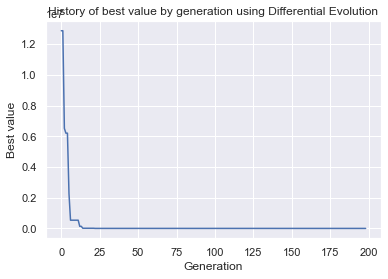

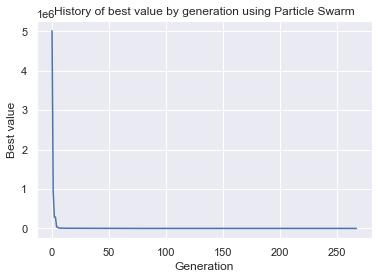

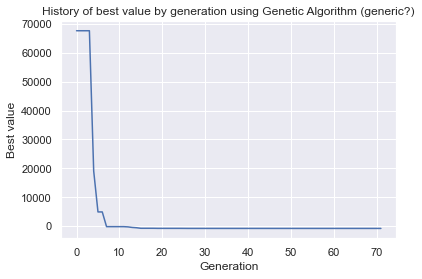

In [20]:
plot(de_his, 'Differential Evolution')
plot(ps_his, 'Particle Swarm')
plot(ga_his, 'Genetic Algorithm (generic?)')

Perhaps it would be a good idea to cut out the first some generations...

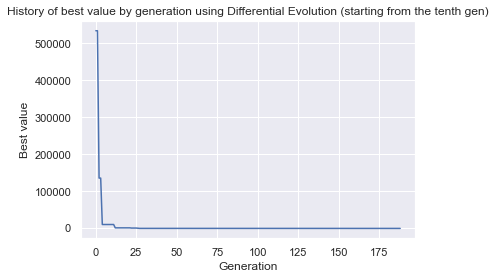

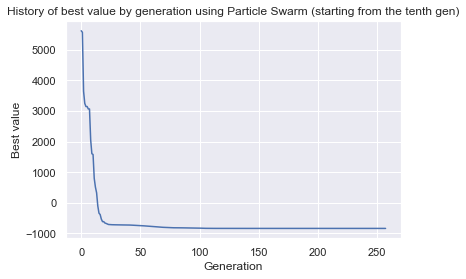

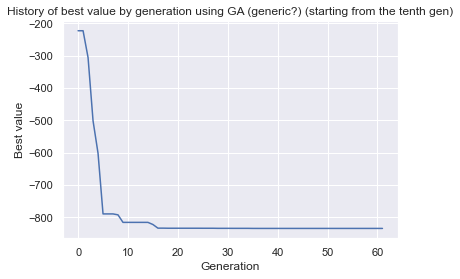

In [21]:
plot(de_his[10:], 'Differential Evolution (starting from the tenth gen)')
plot(ps_his[10:], 'Particle Swarm (starting from the tenth gen)')
plot(ga_his[10:], 'GA (generic?) (starting from the tenth gen)')

It is interesting to see differential evolution, the fastest method so far, go through the most generations. For all of them we see that after a certain point that we reach very quickly results improve very little. Chances are these methods could be modified to stop once improvements are not large enough (as opposed to when there has been absolutely no improvement for a while) to gain some speed.

Also of note is that even if DE takes the least time to run already, it also requires a relatively small *fraction* of its runtime to reach an acceptable point, so possibly it is also the most optimizable.